# Predicting Fraud in Financial Payment Services #
This  datasetis from Kaggle.
Due to the rising risk in financial transactions nowadays, predicting the fraud in financial transactions is very important.


** Predicting Fraud in Financial Payment Services **
## The prediction of Fraud analysis is very important for finacial organisations and equally important for the customers.
The main technical challenge it poses to predicting fraud is the highly imbalanced distribution between positive and negative classes in 6 million rows of data. Another stumbling block to the utility of this data stems from the possible discrepancies in its description [1], [2], [3]. The goal of this analysis is to solve both these issues by a detailed data exploration and cleaning followed by choosing a suitable machine-learning algorithm to deal with the skew. I show that an optimal solution based on feature-engineering and extreme gradient-boosted decision trees yields an enhanced predictive power of 0.997, as measured by the area under the precision-recall curve. Crucially, these results were obtained without artificial balancing of the data making this approach suitable to real-world applications. The prediction of Fraud analysis is very important for finacial organisations and equally important for the customers.

In [ ]:
#Import libraries

In [26]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [ ]:
# Import warnings

In [28]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [34]:
df = pd.read_csv(r"c:\AI\creditcard_log.csv")
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print(df.head())

   step      type   amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT  9839.64  C1231006815       170136.00       160296.36   
1     1   PAYMENT  1864.28  C1666544295        21249.00        19384.72   
2     1  TRANSFER   181.00  C1305486145          181.00            0.00   
3     1  CASH_OUT   181.00   C840083671          181.00            0.00   
4     1   PAYMENT 11668.14  C2048537720        41554.00        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155            0.00            0.00        0               0  
1  M2044282225            0.00            0.00        0               0  
2   C553264065            0.00            0.00        1               0  
3    C38997010        21182.00            0.00        1               0  
4  M1230701703            0.00            0.00        0               0  


In [ ]:
#Import data and column headers for consistency

In [36]:
df.isnull().values.any()

False

In [ ]:
#Here we do the Exploratory Data Analysis

In [38]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) # 4097

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) # 4116


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


In [ ]:
#Identifying the types of Farudulent transactions

In [42]:
print('\nThe number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and\
 newBalanceDest = 0: {}'.\
format(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & \
(dfTransfer.oldBalanceDest == 0) & (dfTransfer.newBalanceDest == 0)]))) # 4158


The number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: 4158


In [ ]:
#Flagging the transactions

In [44]:
print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: {}'.\
format([round(dfFlagged.oldBalanceOrig.min()), round(dfFlagged.oldBalanceOrig.max())]))

print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where \
oldBalanceOrig = \
newBalanceOrig: {}'.format(\
[dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
== dfTransfer.newBalanceOrig)].oldBalanceOrig.min(), \
round(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
               == dfTransfer.newBalanceOrig)].oldBalanceOrig.max())]))


Min, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: [353874, 19585040]

Min, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where oldBalanceOrig = newBalanceOrig: [0.0, 575668]


In [ ]:
#Flagging customers ttransacting more than once

In [46]:
print('\nHave originators of transactions flagged as fraud transacted more than \
once? {}'\
.format((dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig, \
                                    dfNotFlagged.nameDest]))).any())) # False

print('\nHave destinations for transactions flagged as fraud initiated\
 other transactions? \
{}'.format((dfFlagged.nameDest.isin(dfNotFlagged.nameOrig)).any())) # False

# Since only 2 destination accounts of 16 that have 'isFlaggedFraud' set have been
# destination accounts more than once,
# clearly 'isFlaggedFraud' being set is independent of whether a 
# destination account has been used before or not

print('\nHow many destination accounts of transactions flagged as fraud have been \
destination accounts more than once?: {}'\
.format(sum(dfFlagged.nameDest.isin(dfNotFlagged.nameDest)))) # 2


Have originators of transactions flagged as fraud transacted more than once? False

Have destinations for transactions flagged as fraud initiated other transactions? False

How many destination accounts of transactions flagged as fraud have been destination accounts more than once?: 2


In [ ]:
#Showing Merchans making CASH-IN transactions

In [48]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any())) # False


Are there any merchants among originator accounts for CASH_IN transactions? False


In [ ]:
#Showing Merchans making CASH-OUT transactions

In [50]:
print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any())) # False


Are there any merchants among destination accounts for CASH_OUT transactions? False


In [ ]:
#Checking for merchants amon originators

In [52]:
print('\nAre there merchants among any originator accounts? {}'.format(\
      df.nameOrig.str.contains('M').any())) # False

print('\nAre there any transactions having merchants among destination accounts\
 other than the PAYMENT type? {}'.format(\
(df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any())) # False


Are there merchants among any originator accounts? False

Are there any transactions having merchants among destination accounts other than the PAYMENT type? False


In [ ]:
#Checking for account labels common to fraudulent TRANSFERs and CASH_OUTs.

In [54]:
print('\nWithin fraudulent transactions, are there destinations for TRANSFERS \
that are also originators for CASH_OUTs? {}'.format(\
(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any())) # False
dfNotFraud = df.loc[df.isFraud == 0]


Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? False


In [ ]:
#destinations for TRANSFERS that are also originators for CASH_OUTs

In [56]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of \
genuine CASH_OUTs: \n\n{}'.format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))


Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

         step      type     amount     nameOrig  oldBalanceOrig  \
1030443    65  TRANSFER 1282971.57  C1175896731      1282971.57   
6039814   486  TRANSFER  214793.32  C2140495649       214793.32   
6362556   738  TRANSFER  814689.88  C2029041842       814689.88   

         newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest  isFraud  \
1030443            0.00  C1714931087            0.00            0.00        1   
6039814            0.00   C423543548            0.00            0.00        1   
6362556            0.00  C1023330867            0.00            0.00        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


In [ ]:
# Fraudulent TRANSFERs originate CASHOUTs that are not detected and are labeled as genuine

In [58]:
print('\nFraudulent TRANSFER to C423543548 occured at step = 486 whereas \
genuine CASH_OUT from this account occured earlier at step = {}'.format(\
dfNotFraud.loc[(dfNotFraud.type == 'CASH_OUT') & (dfNotFraud.nameOrig == \
                           'C423543548')].step.values)) # 185


Fraudulent TRANSFER to C423543548 occured at step = 486 whereas genuine CASH_OUT from this account occured earlier at step = [185]


In [60]:
# Data cleaning

In [62]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

In [64]:
# Imputation of Latent Missing Values

In [66]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


In [ ]:
# Fraudulent transactions that are not indicated by the nameOrig and nameDest features.

In [68]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1

In [70]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

In [72]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

In [74]:
#Data Visualization

In [135]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
       #ax = sns.stripplot(x, y, hue = hue, jitter = 0.4, marker = '.',size = 4, palette = colours)
        ax = sns.stripplot(x=x, y=y, hue=hue, jitter=0.4, marker='.', size=4, palette=colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

In [88]:
#Dispersion over Tme

In [146]:

    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
%matplotlib inline

<Figure size 1400x900 with 0 Axes>

<Figure size 1400x900 with 0 Axes>

<Figure size 1400x900 with 0 Axes>

<Figure size 1400x900 with 0 Axes>

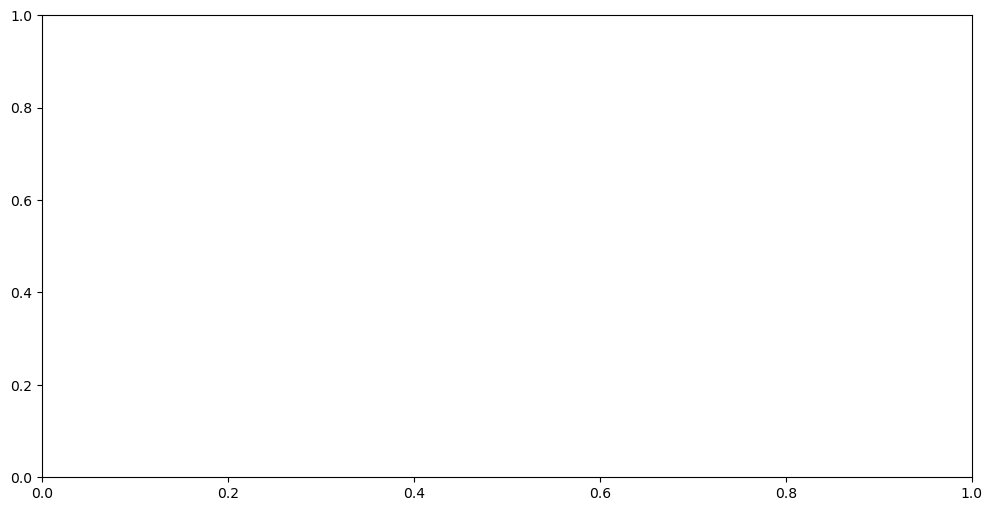

<Figure size 1400x900 with 0 Axes>

<Figure size 1400x900 with 0 Axes>

<Figure size 1400x900 with 0 Axes>

<Figure size 1400x900 with 0 Axes>

<Figure size 1400x900 with 0 Axes>

<Figure size 1400x900 with 0 Axes>

<Figure size 1400x900 with 0 Axes>

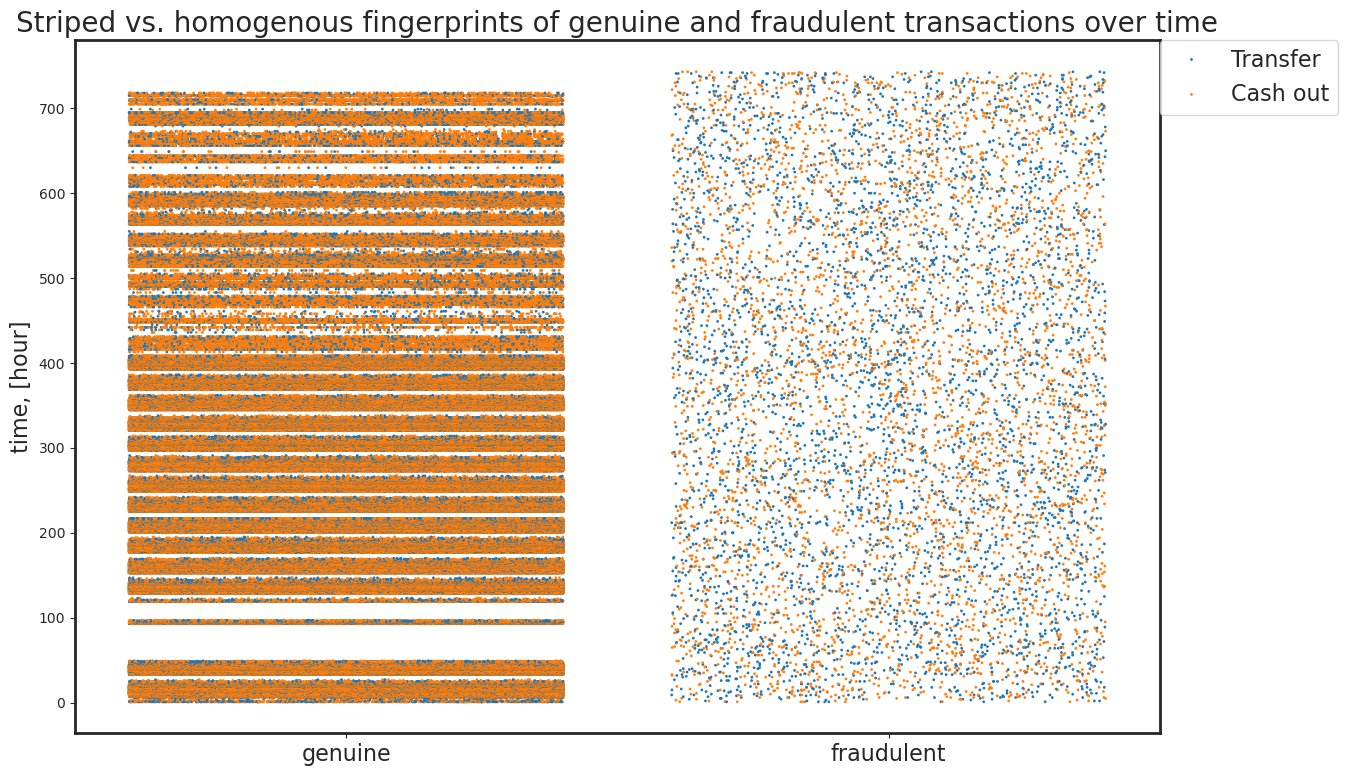

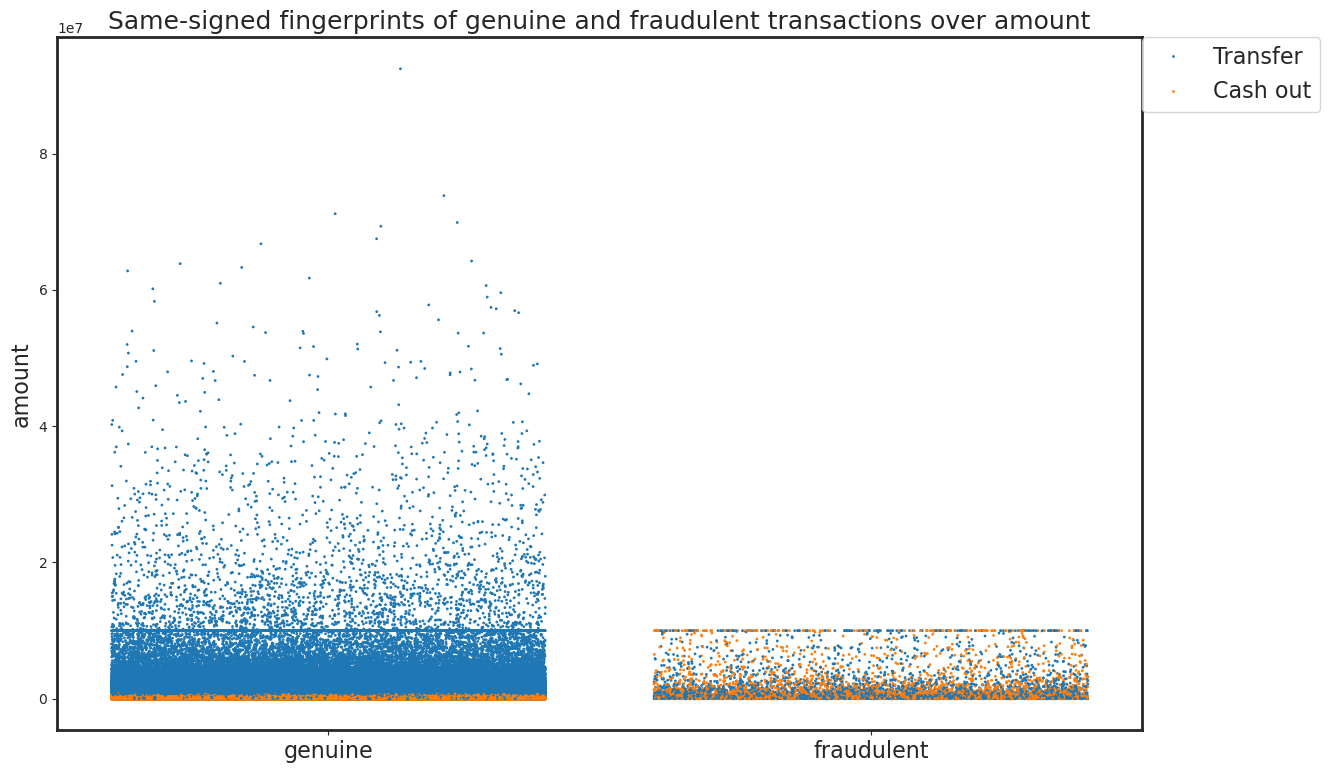

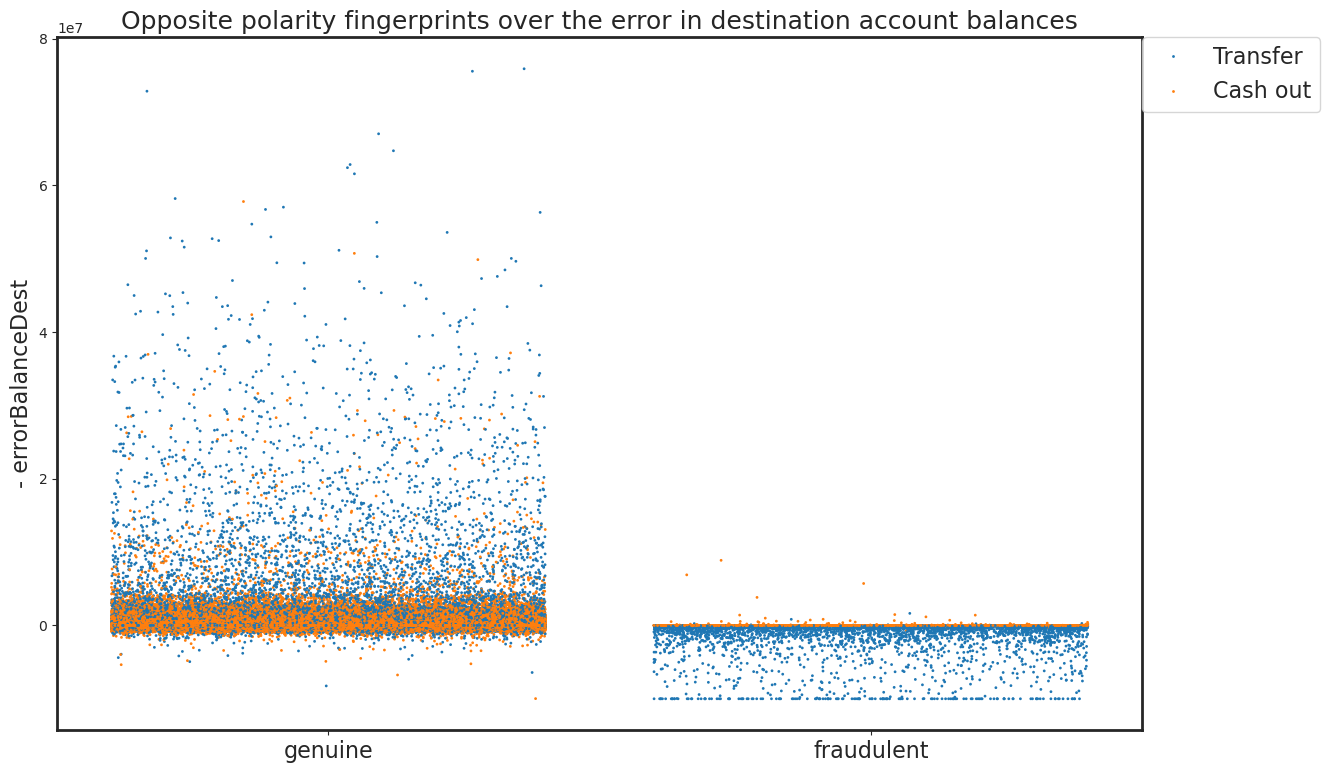

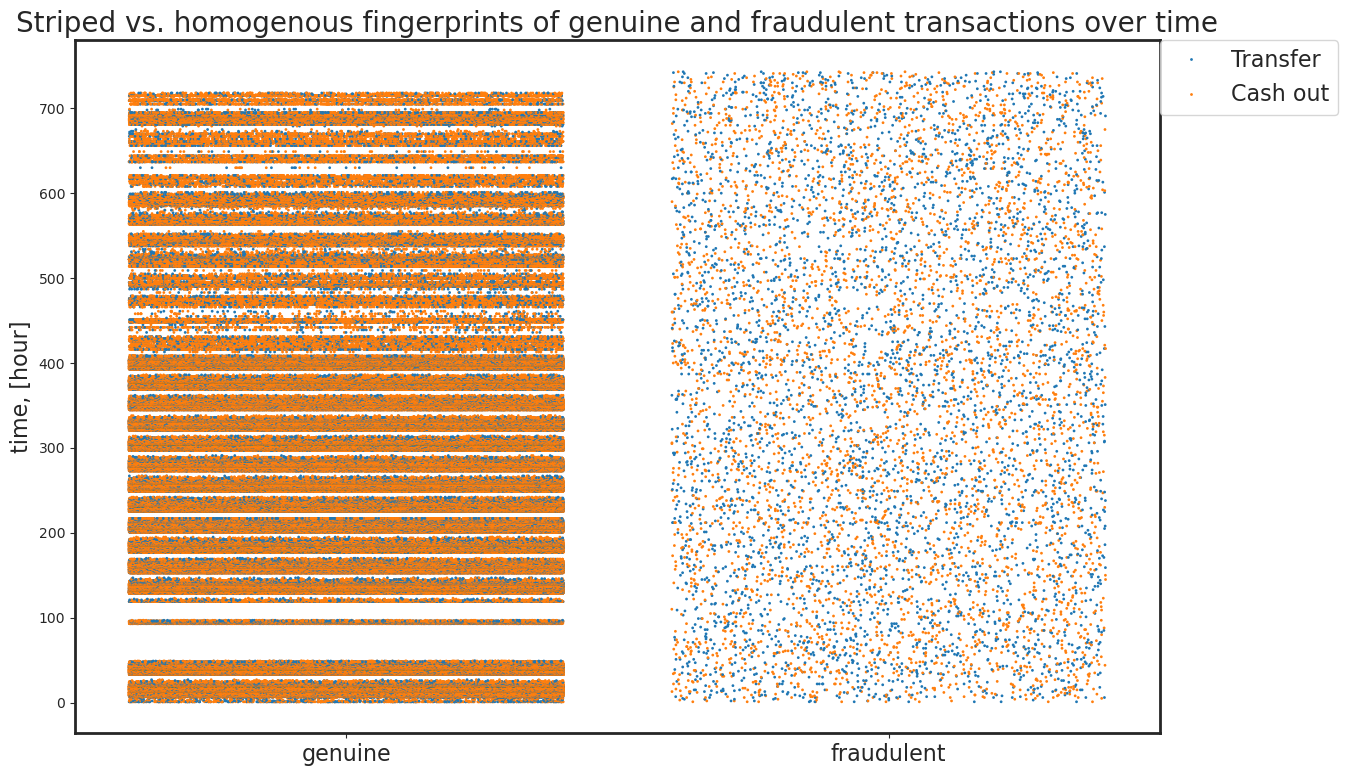

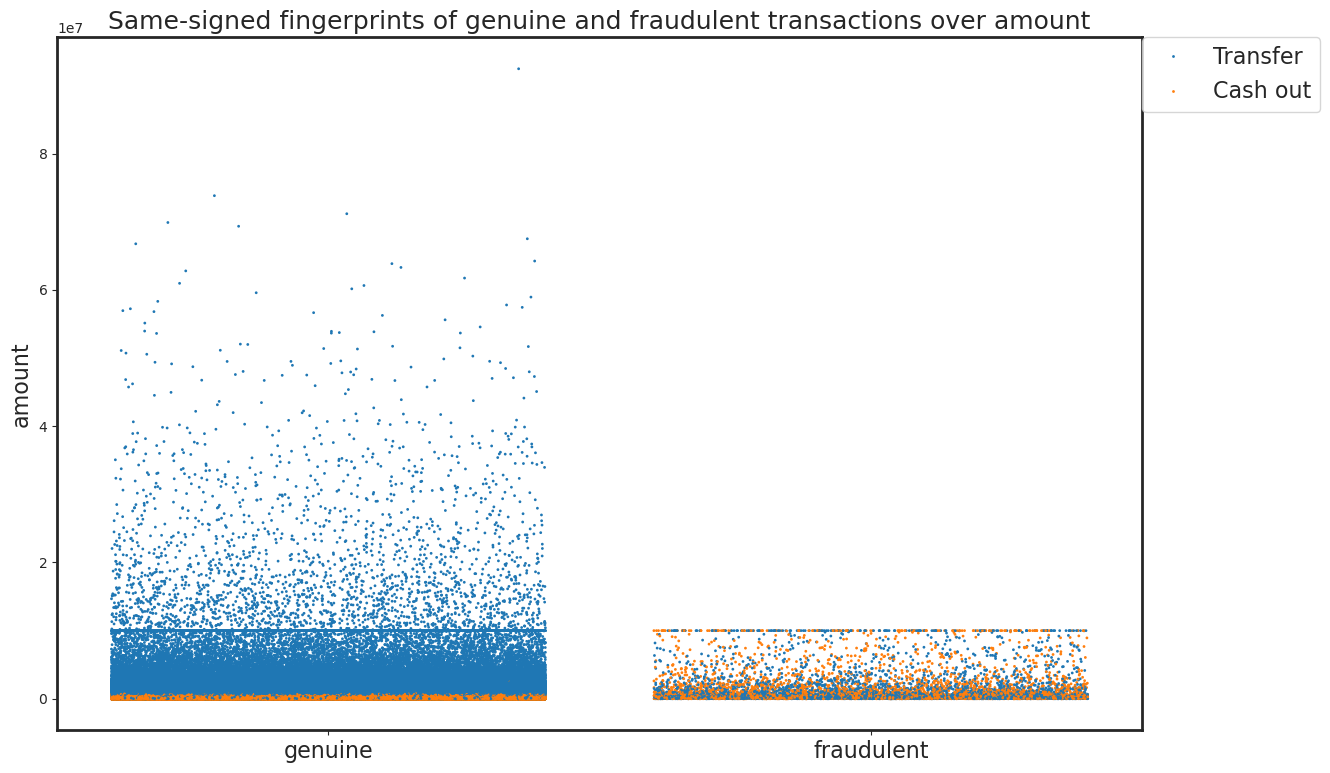

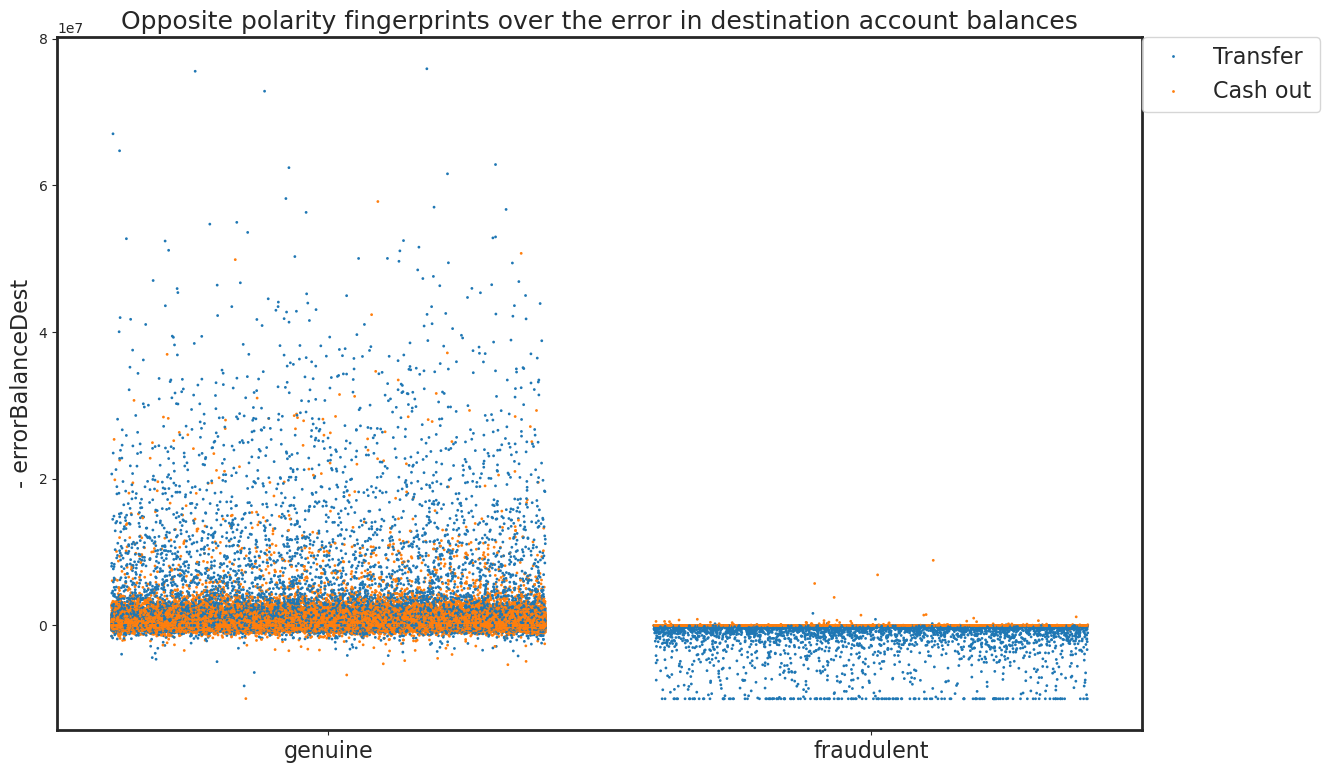

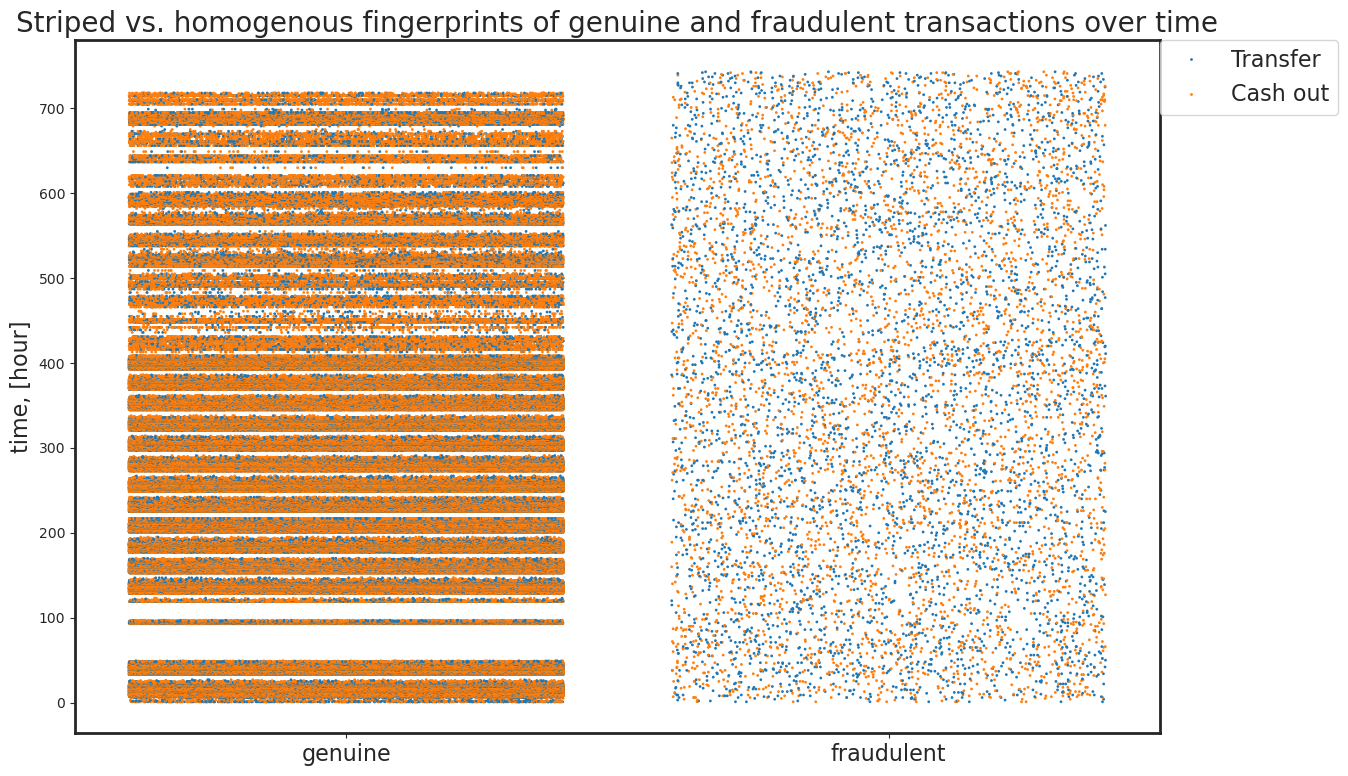

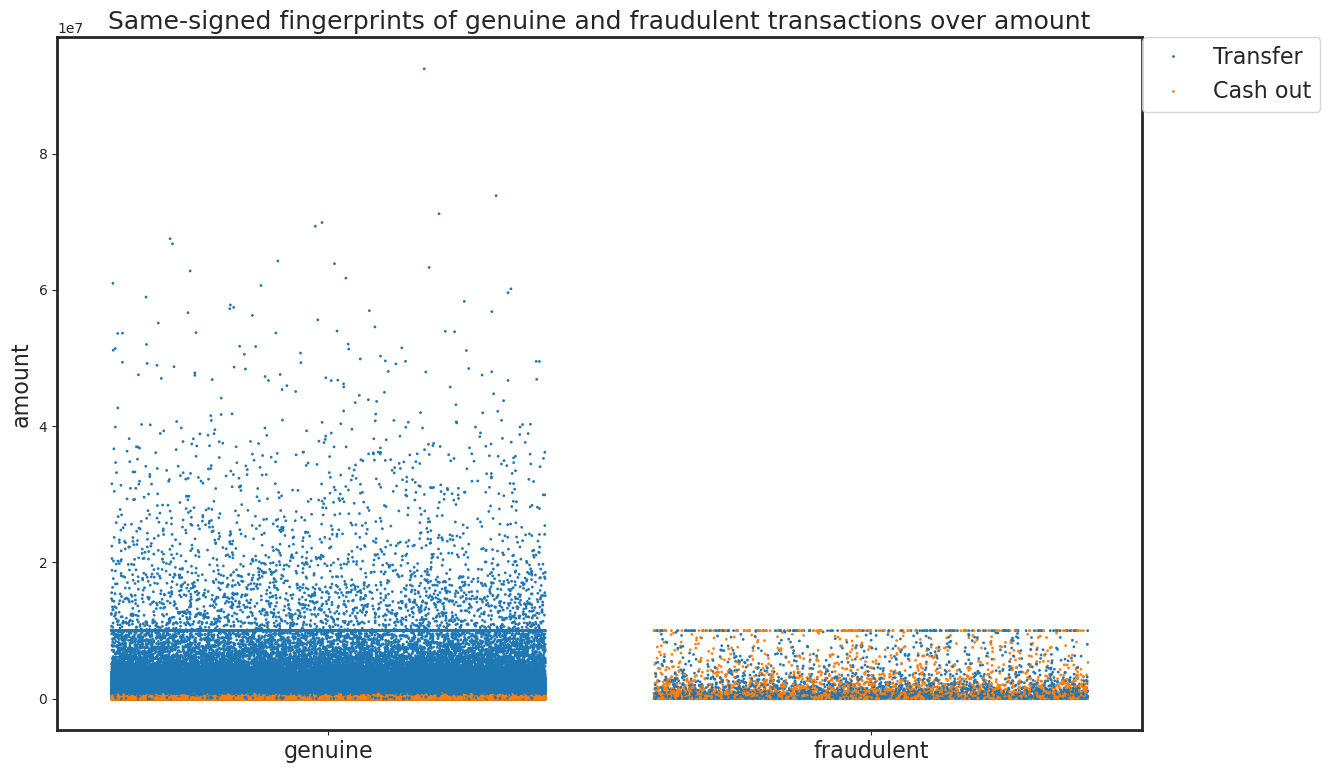

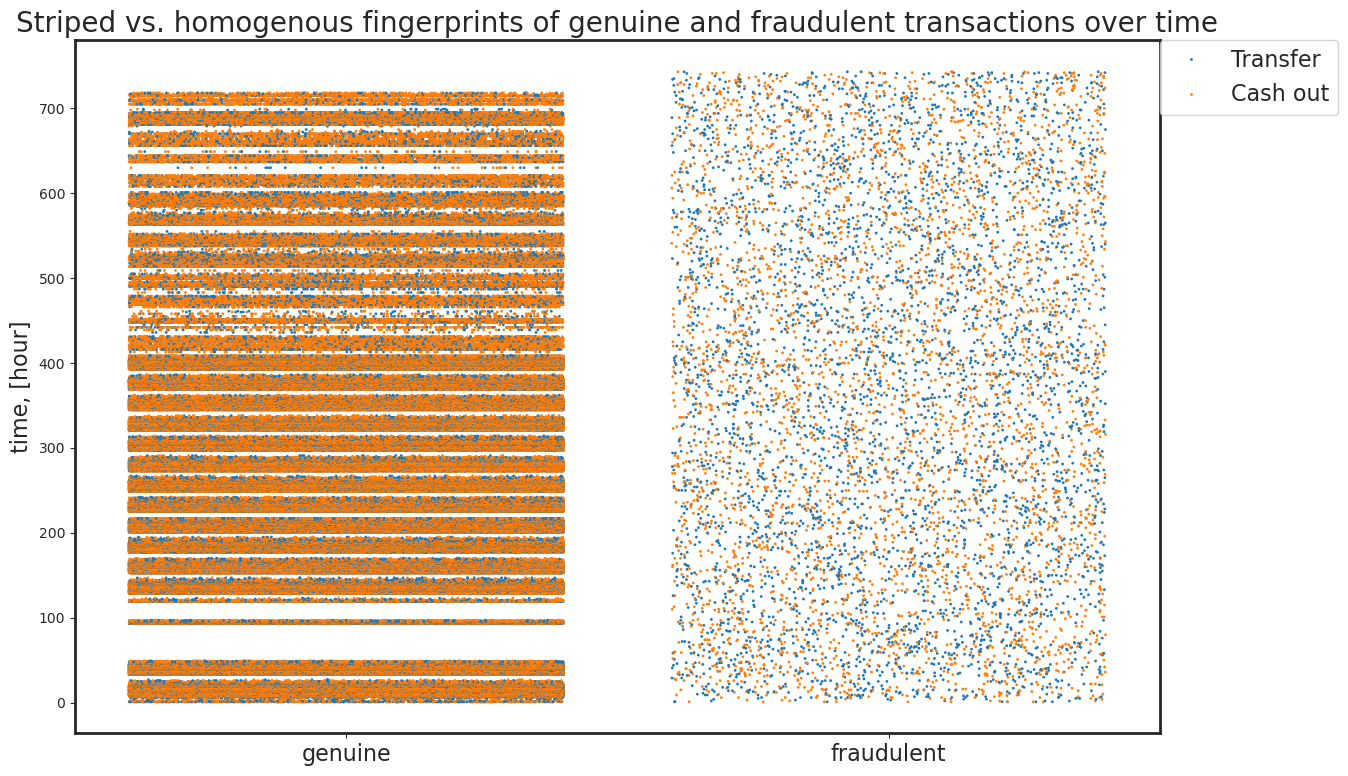

In [145]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time, [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent transactions over time', size = 20);
plt.show()

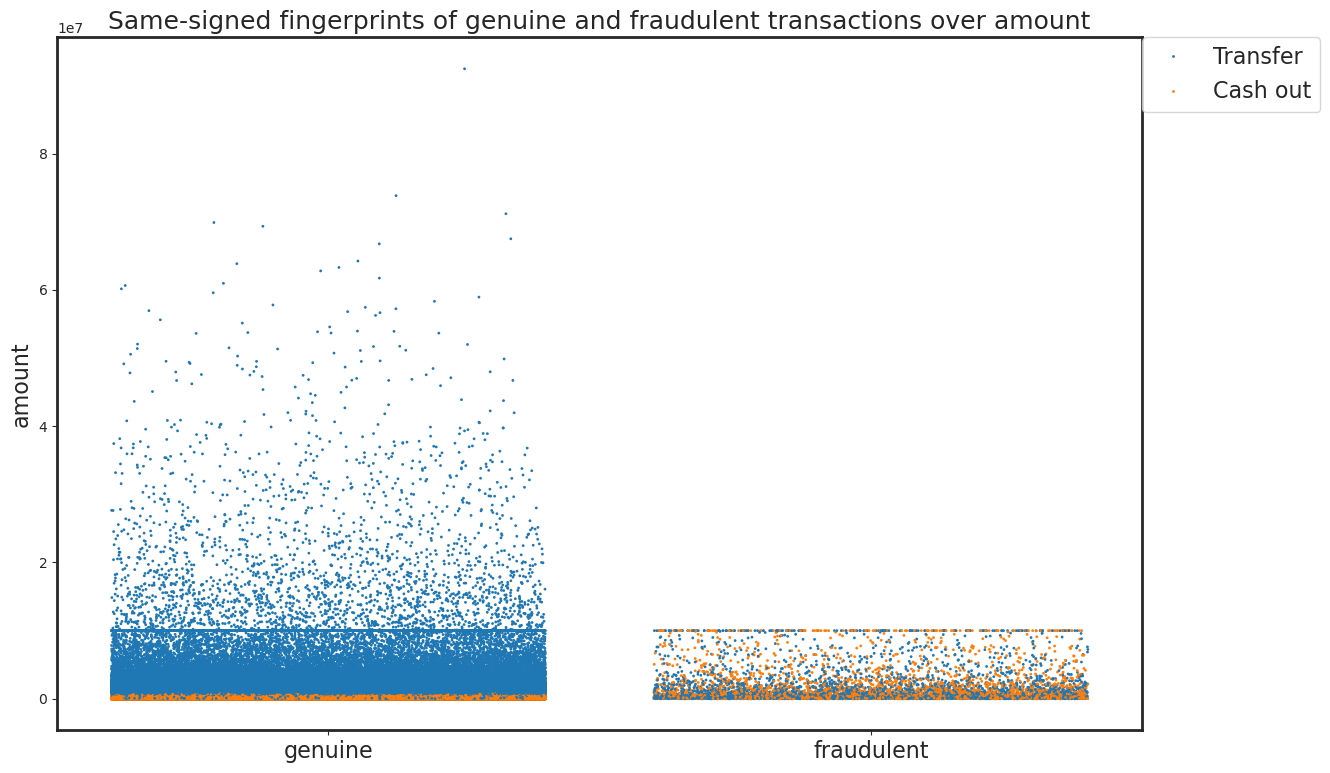

In [150]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);
%matplotlib inline
plt.show()

In [152]:
#Dispersion over error in balance in destination accounts

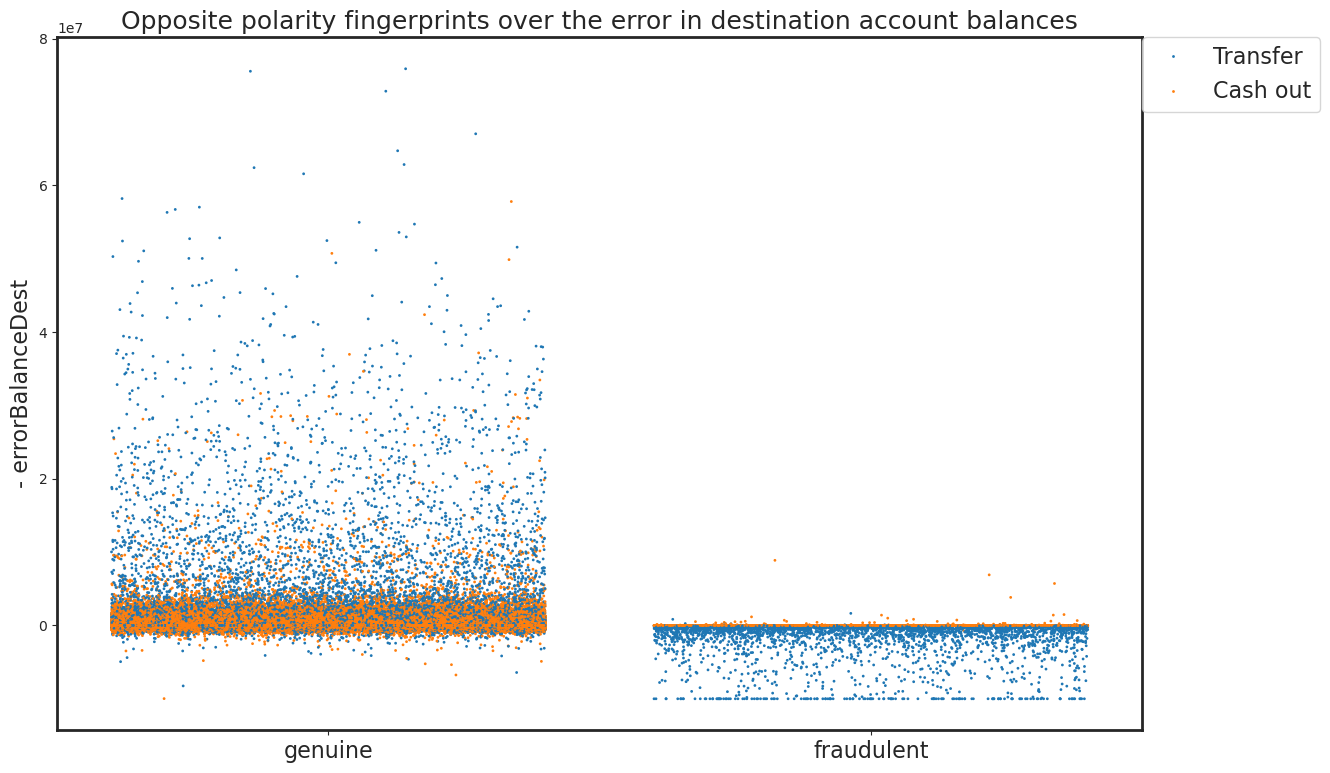

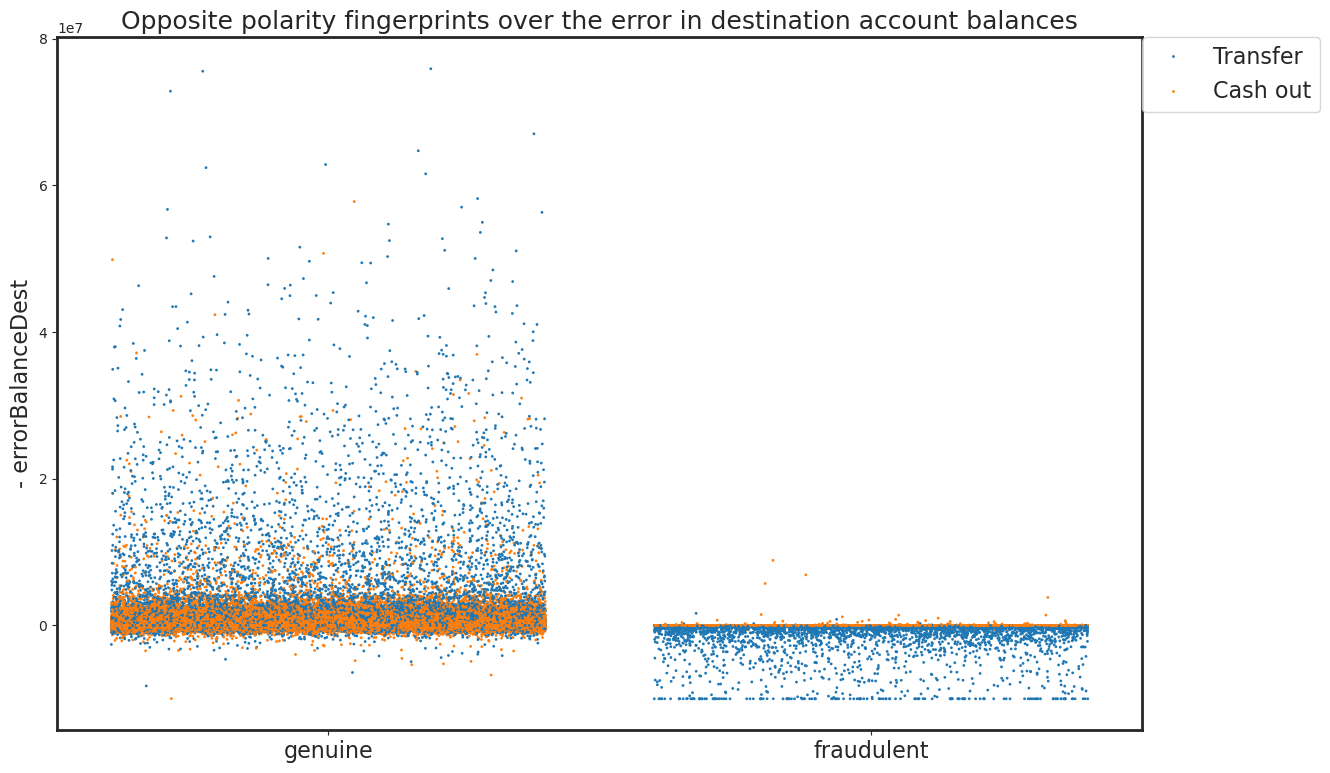

In [155]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);
plt.show()

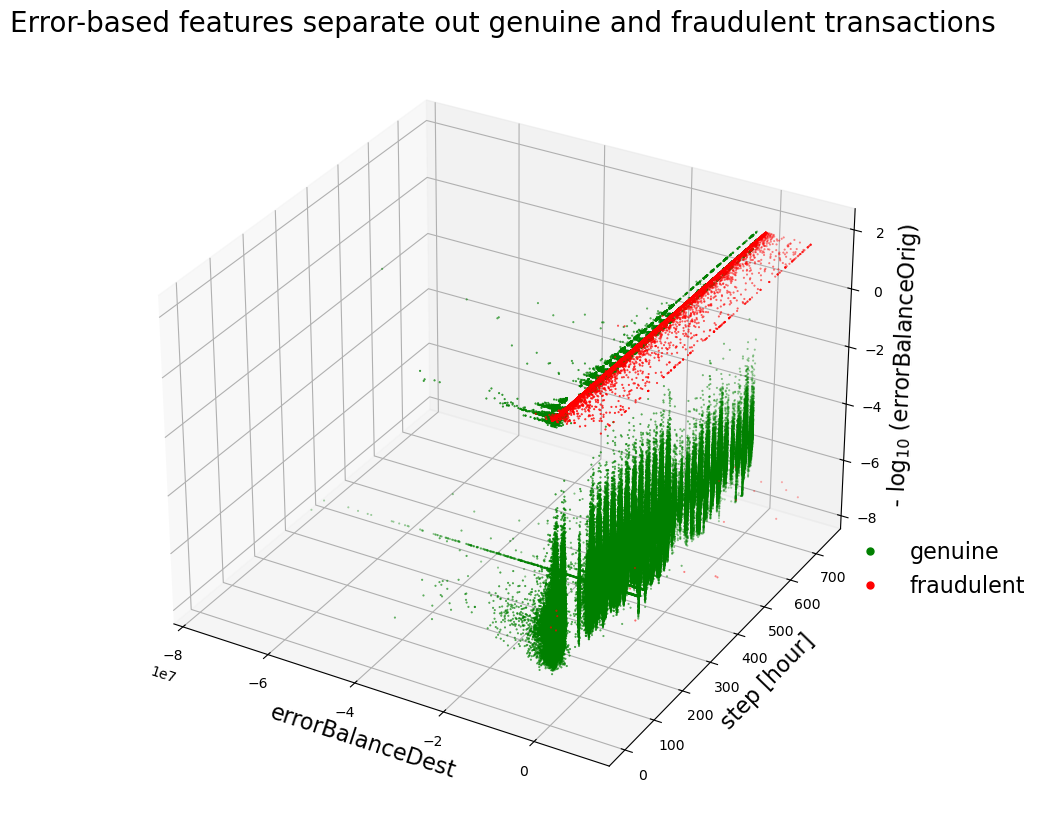

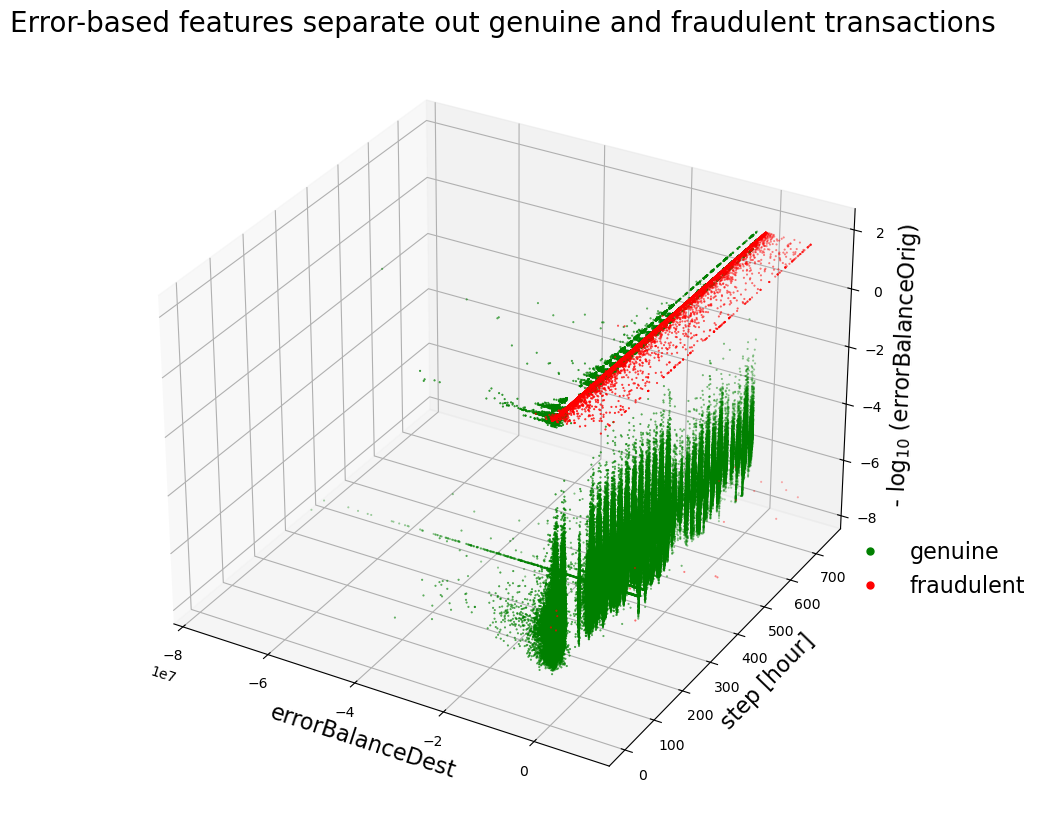

In [159]:
# Long computation in this cell (~2.5 minutes)
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});
plt.show()

In [161]:
#Fingerprints of genuine and fraudulent transactions

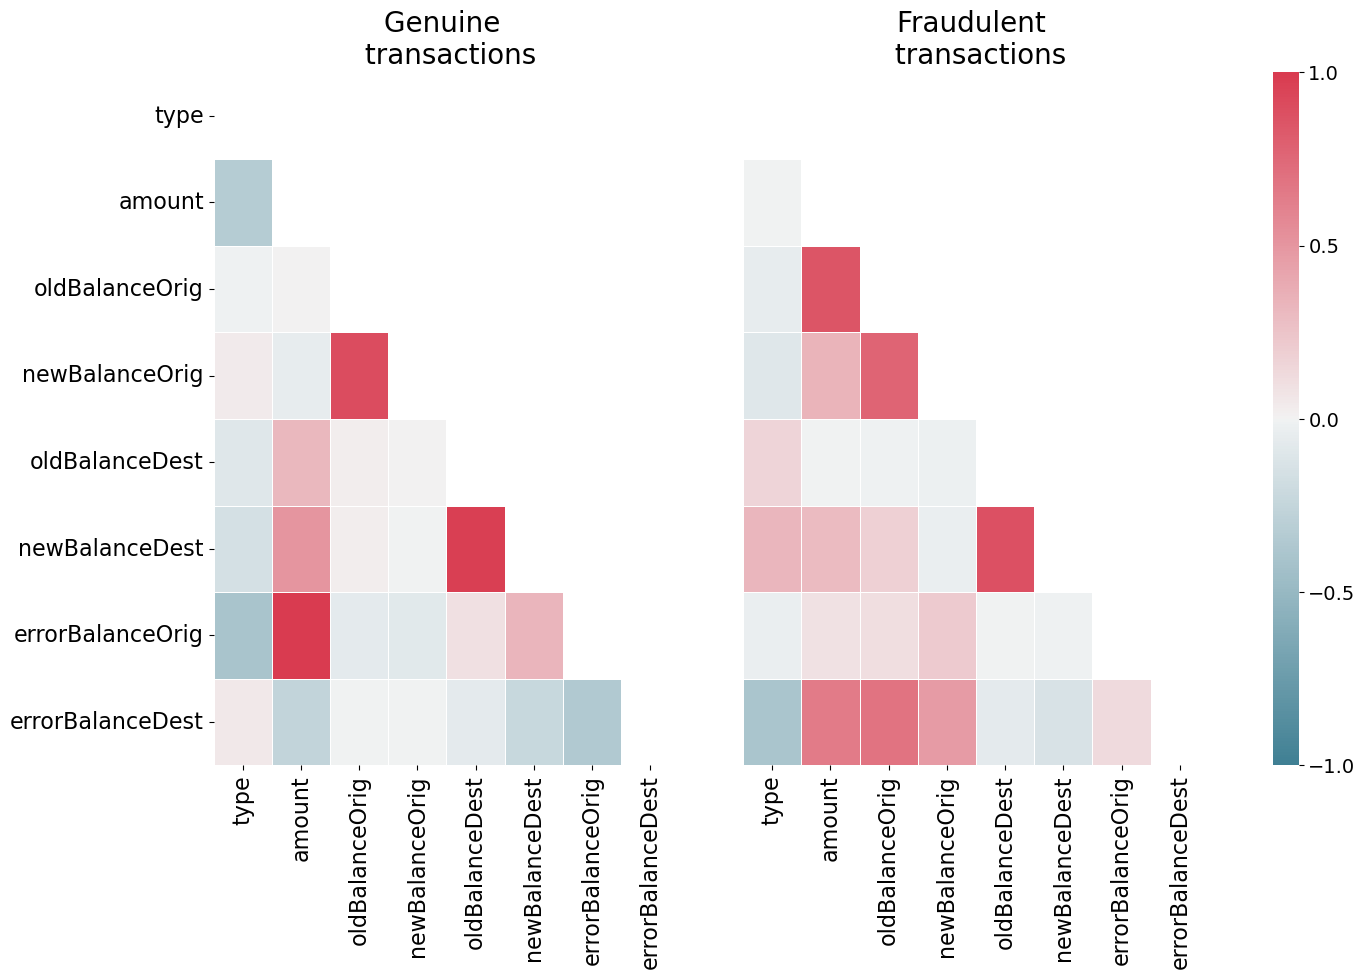

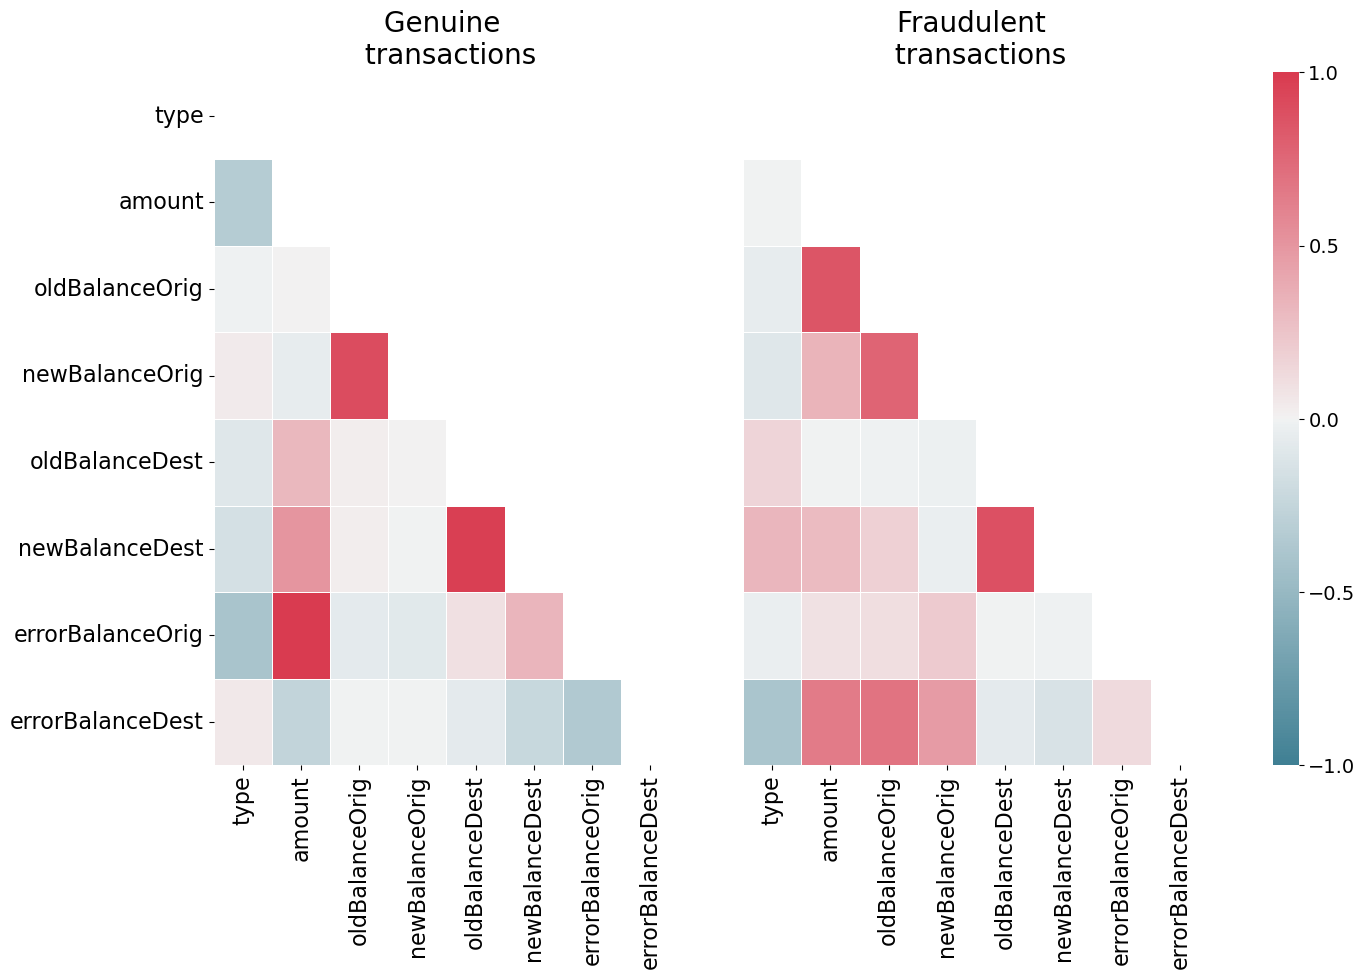

In [165]:
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);
plt.show()